In [5]:
import torch
from torch.utils.data import DataLoader
from dataset import ChestXrayDataset, get_transforms
from ViT_model import ViT

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#define training and validation datasets
train_ds = ChestXrayDataset(
    "data_splits_3/train.txt",
    transform=get_transforms(train=True)
)

val_ds = ChestXrayDataset(
    "data_splits_3/val.txt",
    transform=get_transforms(train=False)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

Using device: cuda


In [7]:
#define model
model = ViT().to(device)

#define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [8]:
#training loop
train_loss_history = []
val_loss_history = []


for epoch in range(30): #train for 30 epochs
    model.train()
    total_loss = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_loss = 0

        for batch_idx, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)

            logits, _ = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item()
            
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    val_loss_history.append(avg_val_loss)
    train_loss_history.append(avg_train_loss)
    
    print(f"Epoch {epoch+1}/{30} Complete | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print("-" * 60)


Epoch 1/30 Complete | Train Loss: 0.9521 | Val Loss: 0.6941
------------------------------------------------------------
Epoch 2/30 Complete | Train Loss: 0.6349 | Val Loss: 0.5495
------------------------------------------------------------
Epoch 3/30 Complete | Train Loss: 0.5580 | Val Loss: 0.6036
------------------------------------------------------------
Epoch 4/30 Complete | Train Loss: 0.5312 | Val Loss: 0.5135
------------------------------------------------------------
Epoch 5/30 Complete | Train Loss: 0.4926 | Val Loss: 0.5581
------------------------------------------------------------
Epoch 6/30 Complete | Train Loss: 0.4876 | Val Loss: 0.5155
------------------------------------------------------------
Epoch 7/30 Complete | Train Loss: 0.4683 | Val Loss: 0.4785
------------------------------------------------------------
Epoch 8/30 Complete | Train Loss: 0.4468 | Val Loss: 0.4489
------------------------------------------------------------
Epoch 9/30 Complete | Train Loss

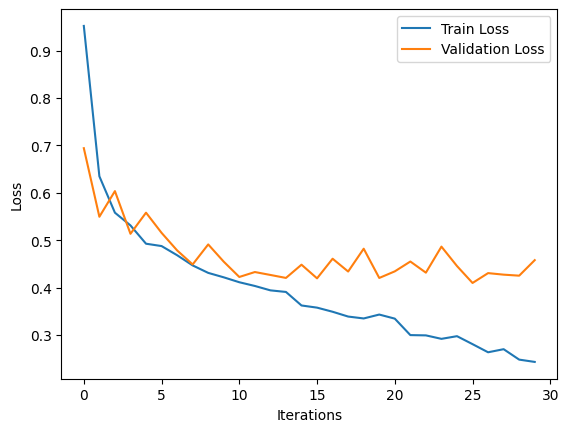

In [9]:
#plotting loss curves
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report

#evaluate per class performance

test_ds = ChestXrayDataset(
    "data_splits_3/test.txt",
    transform=get_transforms(train=False)
)

test_loader = DataLoader(test_ds, batch_size=32)

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        logits, _ = model(x)
        predictions = torch.argmax(logits, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(predictions.cpu().tolist())

print(classification_report(y_true, y_pred, target_names=["Normal", "Bacterial", "Viral", "COVID-19"]))

              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       492
   Bacterial       0.77      0.83      0.80       451
       Viral       0.65      0.58      0.61       249
    COVID-19       0.96      0.98      0.97       124

    accuracy                           0.84      1316
   macro avg       0.84      0.83      0.84      1316
weighted avg       0.84      0.84      0.84      1316



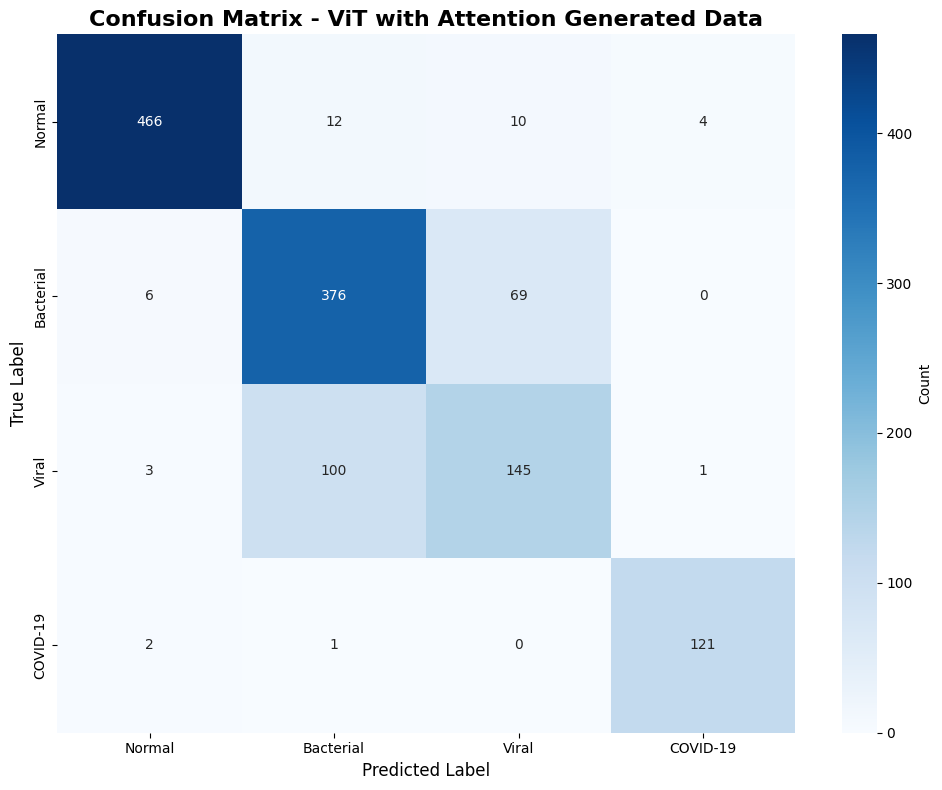


Confusion Matrix:
[[466  12  10   4]
 [  6 376  69   0]
 [  3 100 145   1]
 [  2   1   0 121]]

Per-class accuracy (recall):
Normal: 0.9472
Bacterial: 0.8337
Viral: 0.5823
COVID-19: 0.9758


In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Normal", "Bacterial", "Viral", "COVID-19"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ViT with Attention Generated Data', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print("\nConfusion Matrix:")
print(cm)
print("\nPer-class accuracy (recall):")
for i, class_name in enumerate(class_names):
    if cm[i].sum() > 0:
        accuracy = cm[i, i] / cm[i].sum()
        print(f"{class_name}: {accuracy:.4f}")

In [12]:
#save model
torch.save(model.state_dict(), "vit_with_attn_generated.pth")